In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from multiprocessing import Pool
from itertools import product
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.preprocessing import LabelEncoder


from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
%matplotlib inline

In [34]:
#!kaggle competitions download -c competitive-data-science-predict-future-sales
#!pip install lightgbm
#!pip install xgboost
#!conda install catboost
#!pip install ipywidgets
#!jupyter nbextension enable --py widgetsnbextension

In [35]:
items = pd.read_csv('final_project_data/items.csv')
item_categories = pd.read_csv('final_project_data/item_categories.csv')
sales_train = pd.read_csv('final_project_data/sales_train.csv.gz')
sample_submission = pd.read_csv('final_project_data/sample_submission.csv.gz')
shops = pd.read_csv('final_project_data/shops.csv')
test = pd.read_csv('final_project_data/test.csv.gz')

## Brief data analysis

Here is recommendation from lections:

Try to carefully tune hyper parameters of your models, maybe there is a better set of parameters for your model out there. But don't spend too much time on it. Try ensembling. Start with simple averaging of linear model and gradient boosted trees like in programming assignment notebook. And then try to use stacking. Explore new features! There is a lot of useful information in the data: text descriptions, item categories, seasonal trends.

In [36]:
items.head(3)
item_categories.head(3)
print(sales_train.shape)
sales_train.head(3)
print(test.shape)
test.head(3)
print(sample_submission.shape)
sample_submission.head(3)

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40


,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2


(2935849, 6)


,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.0,1.0
1,03.01.2013,0,25,2552,899.0,1.0
2,05.01.2013,0,25,2552,899.0,-1.0


(214200, 3)


,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233


(214200, 2)


,ID,item_cnt_month
0,0,0.5
1,1,0.5
2,2,0.5


## Prepare some features
Let's prepare features and dataset

In [37]:
# Create "grid" with columns
index_cols = ['shop_id', 'item_id', 'date_block_num']

# For every month we create a grid from all shops/items combinations from that month
# We can not use
sales = sales_train
grid = [] 
for block_num in sales['date_block_num'].unique():
    cur_shops = sales.loc[sales['date_block_num'] == block_num, 'shop_id'].unique()
#     print(cur_shops)
    cur_items = sales.loc[sales['date_block_num'] == block_num, 'item_id'].unique()
#     print(cur_items)
    grid.append(np.array(list(product(*[cur_shops, cur_items, [block_num]])),dtype='int32'))
#     print(grid)

# Turn the grid into a dataframe
grid = pd.DataFrame(np.vstack(grid), columns = index_cols,dtype=np.int32)
# print(grid)

# Groupby data to get shop-item-month aggregates
gb = sales.groupby(index_cols,as_index=False).agg({'item_cnt_day':'sum', 'item_price': 'mean'})
print(gb.head())
gb.rename(columns={'item_cnt_day':'item_cnt_month', 'item_price':'item_mean_price'}, inplace=True)
gb.item_cnt_month.fillna(0, inplace=True)
gb.item_cnt_month.clip(0, 40, inplace=True)

# Join it to the grid
trainset = pd.merge(grid, gb, how='left', on=index_cols).fillna(0)
trainset.head()

   shop_id  item_id  date_block_num  item_cnt_day  item_price
0        0       30               1          31.0       265.0
1        0       31               1          11.0       434.0
2        0       32               0           6.0       221.0
3        0       32               1          10.0       221.0
4        0       33               0           3.0       347.0


,shop_id,item_id,date_block_num,item_cnt_month,item_mean_price
0,59,22154,0,1.0,999.0
1,59,2552,0,0.0,0.0
2,59,2554,0,0.0,0.0
3,59,2555,0,0.0,0.0
4,59,2564,0,0.0,0.0


In [38]:
trainset.isna().sum()

shop_id            0
item_id            0
date_block_num     0
item_cnt_month     0
item_mean_price    0
dtype: int64

In [7]:
shops.head()

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


In [8]:
item_categories.head()

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


In [39]:
import re
# item_categories.item_category_name.apply(lambda x: x.split('-')[0].strip()).to_string()
def get_main_category(item):
    return re.split('-|\(', item)[0].strip().lower() # item.split('-')[0].strip()
def get_sub_category(item):
    x = re.split('-|\(', item)
    x = " ".join(x[1:]).strip().replace(')', '').lower() if len(x) > 1 else ""
    return x

item_categories['item_category_name_main'] = item_categories.item_category_name.apply(get_main_category)
item_categories['item_category_name_sub'] = item_categories.item_category_name.apply(get_sub_category)
item_categories.head(3)

,item_category_name,item_category_id,item_category_name_main,item_category_name_sub
0,PC - Гарнитуры/Наушники,0,pc,гарнитуры/наушники
1,Аксессуары - PS2,1,аксессуары,ps2
2,Аксессуары - PS3,2,аксессуары,ps3


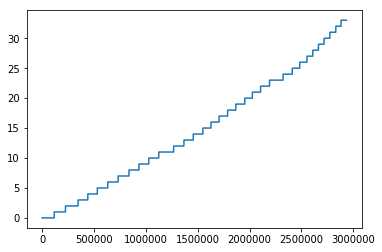

In [40]:
sales.date_block_num.plot()

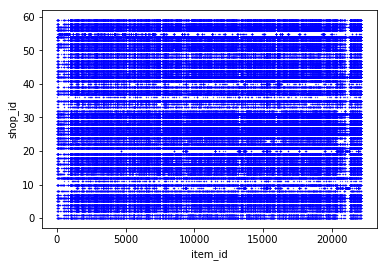

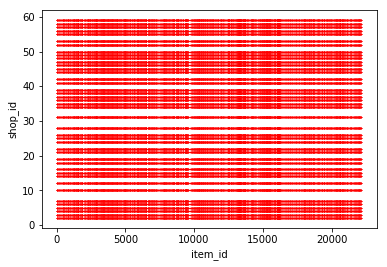

In [11]:
sales.drop_duplicates(subset=['item_id', 'shop_id']).plot.scatter('item_id', 'shop_id', color='Blue', s = 0.1)
test.drop_duplicates(subset=['item_id', 'shop_id']).plot.scatter('item_id', 'shop_id', color='Red', s = 0.1)

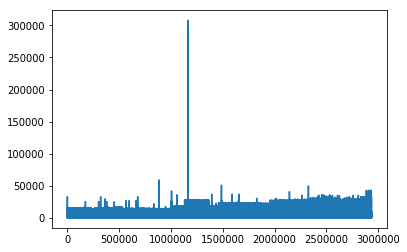

In [12]:
sales.item_price.plot()

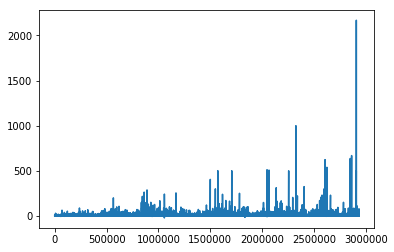

In [13]:
sales.item_cnt_day.plot()

In [14]:
sales[sales.item_cnt_day > 1000]
sales[sales.item_price > 50000]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
2909818,28.10.2015,33,12,11373,0.908714,2169.0


,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
885138,17.09.2013,8,12,11365,59200.0,1.0
1163158,13.12.2013,11,12,6066,307980.0,1.0
1488135,20.03.2014,14,25,13199,50999.0,1.0


In [15]:
items[items.item_id.isin([11365, 6066, 13199, 11373])]

,item_name,item_id,item_category_id
6066,Radmin 3 - 522 лиц.,6066,75
11365,Доставка (EMS),11365,9
11373,Доставка до пункта выдачи (Boxberry),11373,9
13199,Коллекционные шахматы (Властелин Колец),13199,69


In [41]:
finalset = trainset.merge(items, how='left', on=['item_id'])

In [42]:
finalset = finalset.merge(item_categories, how='left', on=['item_category_id'])

In [43]:
testset = test.copy()
testset['date_block_num'] = 34
testset.head()

,ID,shop_id,item_id,date_block_num
0,0,5,5037,34
1,1,5,5320,34
2,2,5,5233,34
3,3,5,5232,34
4,4,5,5268,34


In [44]:
testset.drop(columns=['ID'], axis=1, inplace=True)
testset = testset.merge(items, how='left', on=['item_id'])
testset = testset.merge(item_categories, how='left', on=['item_category_id'])


In [45]:
t1 = pd.concat([finalset, testset], axis=0, sort=True, ignore_index=True)
t1.shape
finalset.shape
testset.shape

(11128050, 10)

(10913850, 10)

(214200, 8)

In [46]:
testset.head(1)
finalset.head(1)
t1.head(1)

,shop_id,item_id,date_block_num,item_name,item_category_id,item_category_name,item_category_name_main,item_category_name_sub
0,5,5037,34,"NHL 15 [PS3, русские субтитры]",19,Игры - PS3,игры,ps3


,shop_id,item_id,date_block_num,item_cnt_month,item_mean_price,item_name,item_category_id,item_category_name,item_category_name_main,item_category_name_sub
0,59,22154,0,1.0,999.0,ЯВЛЕНИЕ 2012 (BD),37,Кино - Blu-Ray,кино,blu ray


,date_block_num,item_category_id,item_category_name,item_category_name_main,item_category_name_sub,item_cnt_month,item_id,item_mean_price,item_name,shop_id
0,0,37,Кино - Blu-Ray,кино,blu ray,1.0,22154,999.0,ЯВЛЕНИЕ 2012 (BD),59


In [47]:
for item in ['item_id', 'shop_id', 'item_category_id']:
    for column_name, new_column_name, agg_func in [
        #('item_price', 'mean_price', np.mean),
        ('item_cnt_month', 'cnt_month', np.sum),
        ('item_cnt_month', 'mean_cnt_month', np.mean)
    ]:
        #t1.groupby([item, 'date_block_num']).head()
        mean_df = t1.groupby([item, 'date_block_num']).agg(agg_func).reset_index()[[column_name, item, 'date_block_num']]
        mean_df.columns = [item + '_' + new_column_name, item, 'date_block_num']
        
        t1 = t1.merge(mean_df, how='left', on=['date_block_num', item])

In [48]:
t1.head(1)
t1.isna().sum()

,date_block_num,item_category_id,item_category_name,item_category_name_main,item_category_name_sub,item_cnt_month,item_id,item_mean_price,item_name,shop_id,item_id_cnt_month,item_id_mean_cnt_month,shop_id_cnt_month,shop_id_mean_cnt_month,item_category_id_cnt_month,item_category_id_mean_cnt_month
0,0,37,Кино - Blu-Ray,кино,blu ray,1.0,22154,999.0,ЯВЛЕНИЕ 2012 (BD),59,18.0,0.4,2021.0,0.249045,6075.0,0.199115


date_block_num                          0
item_category_id                        0
item_category_name                      0
item_category_name_main                 0
item_category_name_sub                  0
item_cnt_month                     214200
item_id                                 0
item_mean_price                    214200
item_name                               0
shop_id                                 0
item_id_cnt_month                       0
item_id_mean_cnt_month             214200
shop_id_cnt_month                       0
shop_id_mean_cnt_month             214200
item_category_id_cnt_month              0
item_category_id_mean_cnt_month    214200
dtype: int64

In [52]:
final_train_table = t1.drop(columns=['item_category_name', 'item_name'])

In [53]:
final_train_table.head(1)

,date_block_num,item_category_id,item_category_name_main,item_category_name_sub,item_cnt_month,item_id,item_mean_price,shop_id,item_id_cnt_month,item_id_mean_cnt_month,shop_id_cnt_month,shop_id_mean_cnt_month,item_category_id_cnt_month,item_category_id_mean_cnt_month
0,0,37,кино,blu ray,1.0,22154,999.0,59,18.0,0.4,2021.0,0.249045,6075.0,0.199115


In [54]:
final_train_table.columns

Index(['date_block_num', 'item_category_id', 'item_category_name_main',
       'item_category_name_sub', 'item_cnt_month', 'item_id',
       'item_mean_price', 'shop_id', 'item_id_cnt_month',
       'item_id_mean_cnt_month', 'shop_id_cnt_month', 'shop_id_mean_cnt_month',
       'item_category_id_cnt_month', 'item_category_id_mean_cnt_month'],
      dtype='object')

In [55]:
lag_columns = [
    'item_cnt_month',
    'item_category_id_cnt_month',
    'item_category_id_mean_cnt_month',
    'item_id_cnt_month',
    'item_id_mean_cnt_month',
    'item_mean_price',
    'shop_id_cnt_month',
    'shop_id_mean_cnt_month',
#    'item_category_name',
#    'item_name',
]
lags = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
#lags = [1, 2, 3]

In [56]:
for lag in lags:
    print("next iteration: started: ", lag)
    df_copy = final_train_table.copy()
    df_copy.date_block_num += lag
    df_copy = df_copy[['date_block_num', 'shop_id', 'item_id'] + lag_columns]
    df_copy.columns = ['date_block_num', 'shop_id', 'item_id']+ [lag_feat+'_lag_'+str(lag) for lag_feat in lag_columns]

    final_train_table = final_train_table.merge(df_copy, on = ['date_block_num', 'shop_id', 'item_id'], how = 'left')
    print("next iteration: done: ", lag)

next iteration: started:  1
next iteration: done:  1
next iteration: started:  2
next iteration: done:  2
next iteration: started:  3
next iteration: done:  3
next iteration: started:  4
next iteration: done:  4
next iteration: started:  5
next iteration: done:  5
next iteration: started:  6
next iteration: done:  6
next iteration: started:  7
next iteration: done:  7
next iteration: started:  8
next iteration: done:  8
next iteration: started:  9
next iteration: done:  9
next iteration: started:  10
next iteration: done:  10
next iteration: started:  11
next iteration: done:  11
next iteration: started:  12
next iteration: done:  12


In [57]:
#drop useless columns
drop_columns = lag_columns[1:] # keep 'item_cnt_month - it is target !'
final_train_table = final_train_table[final_train_table['date_block_num'] >= max(lags)]

In [58]:
final_train_table[final_train_table.date_block_num<34].isna().sum()

date_block_num                                  0
item_category_id                                0
item_category_name_main                         0
item_category_name_sub                          0
item_cnt_month                                  0
item_id                                         0
item_mean_price                                 0
shop_id                                         0
item_id_cnt_month                               0
item_id_mean_cnt_month                          0
shop_id_cnt_month                               0
shop_id_mean_cnt_month                          0
item_category_id_cnt_month                      0
item_category_id_mean_cnt_month                 0
item_cnt_month_lag_1                      1360816
item_category_id_cnt_month_lag_1          1360816
item_category_id_mean_cnt_month_lag_1     1360816
item_id_cnt_month_lag_1                   1360816
item_id_mean_cnt_month_lag_1              1360816
item_mean_price_lag_1                     1360816


In [59]:
#fill nans with default values
for column in final_train_table.columns:
    if 'cnt' in column:
        final_train_table[column] = final_train_table[column].fillna(0)
    elif 'mean_price' in column:
        final_train_table[column] = final_train_table[column].fillna(final_train_table[column].median())

In [60]:
final_train_table.head(1)

,date_block_num,item_category_id,item_category_name_main,item_category_name_sub,item_cnt_month,item_id,item_mean_price,shop_id,item_id_cnt_month,item_id_mean_cnt_month,...,shop_id_cnt_month_lag_11,shop_id_mean_cnt_month_lag_11,item_cnt_month_lag_12,item_category_id_cnt_month_lag_12,item_category_id_mean_cnt_month_lag_12,item_id_cnt_month_lag_12,item_id_mean_cnt_month_lag_12,item_mean_price_lag_12,shop_id_cnt_month_lag_12,shop_id_mean_cnt_month_lag_12
4488756,12,37,кино,blu ray,4.0,10297,749.0,54,23.0,0.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


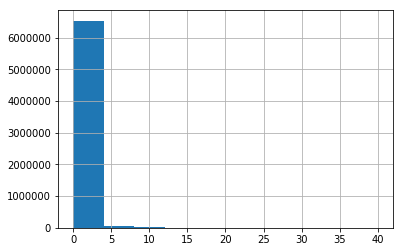

In [61]:
final_train_table.item_cnt_month.hist()

In [62]:
final_train_table.item_cnt_month.clip(0, 20, inplace=True)

In [63]:
lr = LabelEncoder()
final_train_table.item_category_name_main = lr.fit_transform(final_train_table.item_category_name_main.astype(str))

In [64]:
lr = LabelEncoder()
final_train_table.item_category_name_sub = lr.fit_transform(final_train_table.item_category_name_sub.astype(str))

In [65]:
final_train_table.drop(columns=drop_columns, axis=1, inplace=True)

In [67]:
final_train_table.to_csv('final_train_table.csv', index=False)